# Attention Mechanism
- Q = Query : t 시점의 디코더 셀에서의 은닉 상태
- K = Keys : 모든 시점의 인코더 셀의 은닉 상태들
- V = Values : 모든 시점의 인코더 셀의 은닉 상태들

## 닷-프로덕트 어텐션(Dot-Product Attention)
- 어텐션 스코어(Attention Score)를 구한다.
- 소프트맥스(softmax) 함수를 통해 어텐션 분포(Attention Distribution)를 구한다.
- 각 인코더의 어텐션 가중치와 은닉 상태를 가중합하여 어텐션 값(Attention Value)을 구한다.
- 어텐션 값과 디코더의 t 시점의 은닉 상태를 연결한다.(Concatenate)
- 출력층 연산의 입력이 되는 s~t를 계산한다.
- s~t 를 출력층의 입력으로 사용한다.

# 양방향 LSTM과 어텐션 메커니즘(BiLSTM with Attention mechanism)

## 1. IMDB 리뷰 데이터 전처리하기
- Test data 25,000건중 10,000건은 Validation data로 활용

In [1]:
import numpy as np
import tensorflow as tf
seed = 2021
np.random.seed(seed)
tf.random.set_seed(seed)

In [2]:
import warnings
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning) 

In [3]:
from tensorflow.keras.datasets import imdb
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [4]:
vocab_size = 10000
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words = vocab_size)

17465344/17464789 [==============================] - 0s 0us/step


In [5]:
print('리뷰의 최대 길이 : {}'.format(max(len(l) for l in X_train)))
print('리뷰의 평균 길이 : {}'.format(sum(map(len, X_train))/len(X_train)))

리뷰의 최대 길이 : 2494
리뷰의 평균 길이 : 238.71364


In [6]:
max_len = 500
X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

- Test data set을 검증 셋과 테스트 셋으로 분리

In [7]:
from sklearn.model_selection import train_test_split
X_val, X_test, y_val, y_test = train_test_split(
    X_test, y_test, stratify=y_test, test_size=.6, random_state=seed
)

## 2. 바다나우 어텐션(Bahdanau Attention)

In [8]:
class BahdanauAttention(tf.keras.Model):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = Dense(units)
    self.W2 = Dense(units)
    self.V = Dense(1)

  def call(self, values, query): # 단, key와 value는 같음
    # query shape == (batch_size, hidden size)
    # hidden_with_time_axis shape == (batch_size, 1, hidden size)
    # score 계산을 위해 뒤에서 할 덧셈을 위해서 차원을 변경해 줌
    hidden_with_time_axis = tf.expand_dims(query, 1)

    # score shape == (batch_size, max_length, 1)
    # we get 1 at the last axis because we are applying score to self.V
    # the shape of the tensor before applying self.V is (batch_size, max_length, units)
    score = self.V(tf.nn.tanh(
        self.W1(values) + self.W2(hidden_with_time_axis)))

    # attention_weights shape == (batch_size, max_length, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * values
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

## 3. 양방향 LSTM + 어텐션 메커니즘(BiLSTM with Attention Mechanism)

In [9]:
from tensorflow.keras.layers import Dense, Embedding, Bidirectional, LSTM, Concatenate, Dropout
from tensorflow.keras import Input, Model
from tensorflow.keras import optimizers
import os

In [10]:
sequence_input = Input(shape=(max_len,), dtype='int32')
embedded_sequences = Embedding(vocab_size, 128, input_length=max_len, mask_zero = True)(sequence_input)

In [11]:
lstm = Bidirectional(LSTM(64, dropout=0.5, return_sequences = True))(embedded_sequences)

In [12]:
lstm, forward_h, forward_c, backward_h, backward_c = Bidirectional \
  (LSTM(64, dropout=0.5, return_sequences=True, return_state=True))(lstm)

In [13]:
lstm.shape, forward_h.shape, forward_c.shape, backward_h.shape, backward_c.shape

(TensorShape([None, 500, 128]),
 TensorShape([None, 64]),
 TensorShape([None, 64]),
 TensorShape([None, 64]),
 TensorShape([None, 64]))

In [14]:
state_h = Concatenate()([forward_h, backward_h]) # 은닉 상태
state_c = Concatenate()([forward_c, backward_c]) # 셀 상태

In [15]:
attention = BahdanauAttention(64) # 가중치 크기 정의
context_vector, attention_weights = attention(lstm, state_h)

In [16]:
dense1 = Dense(20, activation="relu")(context_vector)
dropout = Dropout(0.5)(dense1)
output = Dense(1, activation="sigmoid")(dropout)
model = Model(inputs=sequence_input, outputs=output)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 500)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 500, 128)     1280000     input_1[0][0]                    
__________________________________________________________________________________________________
bidirectional (Bidirectional)   (None, 500, 128)     98816       embedding[0][0]                  
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) [(None, 500, 128), ( 98816       bidirectional[0][0]              
______________________________________________________________________________________________

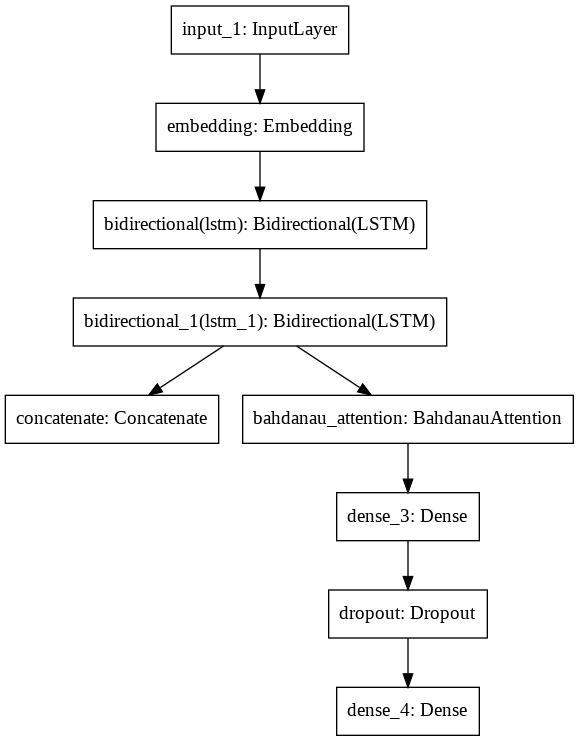

In [17]:
from tensorflow.keras.utils import plot_model
plot_model(model)

In [18]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [19]:
history = model.fit(X_train, y_train, epochs=5, batch_size=256, 
                    validation_data=(X_val, y_val), verbose=1)

Epoch 1/5
98/98 [==============================] - 404s 4s/step - loss: 0.5812 - accuracy: 0.6707 - val_loss: 0.2825 - val_accuracy: 0.8833
Epoch 2/5
98/98 [==============================] - 385s 4s/step - loss: 0.2452 - accuracy: 0.9143 - val_loss: 0.2838 - val_accuracy: 0.8854
Epoch 3/5
98/98 [==============================] - 381s 4s/step - loss: 0.1744 - accuracy: 0.9425 - val_loss: 0.3002 - val_accuracy: 0.8766
Epoch 4/5
98/98 [==============================] - 383s 4s/step - loss: 0.1390 - accuracy: 0.9568 - val_loss: 0.3903 - val_accuracy: 0.8507
Epoch 5/5
98/98 [==============================] - 385s 4s/step - loss: 0.1259 - accuracy: 0.9603 - val_loss: 0.4081 - val_accuracy: 0.8646


In [20]:
print("\n 테스트 정확도: %.4f" % (model.evaluate(X_test, y_test)[1]))

469/469 [==============================] - 178s 380ms/step - loss: 0.4123 - accuracy: 0.8651

 테스트 정확도: 0.8651
